<a href="https://colab.research.google.com/github/yonatanlou/study_projects/blob/main/Statistics_lab/labs/Lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Lab 7 - Matan Polke, Eitan Zimmerman, Yonatan Lourie

In [ ]:
# Import modules 
import numpy as np
import pandas as pd 
from scipy.spatial.distance import mahalanobis
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('bmh')

from functools import partialmethod
pd.DataFrame.head = partialmethod(pd.DataFrame.head, n=10)
pd.options.display.float_format = "{:,.4f}".format
pd.get_option("display.max_columns")

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display

### Import the data

In [ ]:
data_ballot_2021 = "https://raw.githubusercontent.com/yonatanlou/study_projects/main/Statistics_lab/votes_per_ballot_2021.csv"
data_ballot_2020 = "https://raw.githubusercontent.com/yonatanlou/study_projects/main/Statistics_lab/votes_per_ballot_2020.csv"
ballot_2021 = pd.read_csv(data_ballot_2021,  encoding = 'iso-8859-8', index_col='שם ישוב')
ballot_2020 = pd.read_csv(data_ballot_2020,  encoding = 'iso-8859-8', index_col='שם ישוב')



ballot_2021 = ballot_2021.iloc[:,:-1]
ballot_2020 = ballot_2020.iloc[:,:-1]
ballot_2021 = ballot_2021.loc[~ballot_2021.index.str.fullmatch('מעטפות חיצוניות')]
ballot_2020 = ballot_2020.loc[~ballot_2020.index.str.fullmatch('מעטפות חיצוניות')]


In [ ]:
parties_dict ={'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה", 'ט'  : "הציונות הדתית",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "כחול לבן", 'שס'  : "שס"}

Some cleaning

In [ ]:
biggest_2021 = ballot_2021.iloc[:,1:].sum().sort_values(ascending=False)[:13].index.to_list()
biggest_2020 = ballot_2020.iloc[:,1:].sum().sort_values(ascending=False)[:13].index.to_list()

### Q1.

#### a. Matching of the ballots by years.

##### Data manipulation
First, we will normalize the data:

In [ ]:
ballot_2021_raw = ballot_2021.copy()
ballot_2020_raw = ballot_2020.copy()

In [ ]:
#normalize the data (only the n_ij)

ballot_2021.iloc[:,10:] = ballot_2021.iloc[:,10:].div(ballot_2021.iloc[:,10:].sum(axis=1), axis=0)
ballot_2020.iloc[:,10:] = ballot_2020.iloc[:,10:].div(ballot_2020.iloc[:,10:].sum(axis=1), axis=0)

next, we will make the neccesesary matches between 2020 and 2021.

2021:

In [ ]:
# Compute votes share only for parties above a certain threshold 
def parties_votes_percents(df, thresh):
    par = df.sum().div(df.sum().sum()).sort_values(ascending=False)
    return par[par > thresh]

In [ ]:
# # update the data with the parties above the  threshold
total_votes = parties_votes_percents(ballot_2021.iloc[:,10:], 0.0325)  # total votes for each party
names = total_votes.keys().to_list()

df_2021_a = ballot_2021[names +["קלפי"]]
df_2021_a_raw = ballot_2021_raw[names +["קלפי"]]
df_2021_a_raw

,מחל,פה,ודעם,שס,כן,ל,עם,אמת,ב,ג,ט,מרצ,ת,קלפי
שם ישוב,,,,,,,,,,,,,,
אבירים,0.0333,0.1800,0.0200,0.0067,0.1067,0.0133,0.0000,0.3133,0.0000,0.0000,0.0133,0.2067,0.0533,1.0000
אדירים,0.4667,0.0111,0.0000,0.3389,0.0167,0.0000,0.0000,0.0056,0.0389,0.0222,0.0500,0.0000,0.0333,1.0000
אושה,0.0870,0.3116,0.0109,0.0000,0.1341,0.0290,0.0000,0.2609,0.0254,0.0000,0.0000,0.0725,0.0543,1.0000
אחווה,0.1862,0.2552,0.0000,0.0138,0.2483,0.0207,0.0000,0.0966,0.0276,0.0000,0.0276,0.0690,0.0552,1.0000
איבים,0.4250,0.0000,0.0000,0.0250,0.1250,0.0000,0.0000,0.0000,0.1000,0.0000,0.2500,0.0000,0.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
קורנית,0.0652,0.3055,0.0020,0.0000,0.1487,0.0204,0.0000,0.1813,0.0367,0.0000,0.0061,0.1996,0.0305,1.0000
שורשים,0.1103,0.2793,0.0103,0.0000,0.1310,0.0241,0.0000,0.2069,0.0655,0.0000,0.0034,0.0724,0.0862,1.0000
שכניה,0.0315,0.2719,0.0067,0.0022,0.1371,0.0270,0.0000,0.2270,0.0382,0.0000,0.0090,0.1528,0.0809,1.0000


In [ ]:
#cities that arent in 2020
cities_to_remove = ['באר מילכה' , 'מעלה שומרון' , 'עמיחי' , 'פלך' , 'רותם', 'מעטפות חיצוניות']
for city in cities_to_remove:
  df_2021_a = df_2021_a.loc[~df_2021_a.index.str.fullmatch(city)]
  df_2021_a_raw = df_2021_a_raw.loc[~df_2021_a_raw.index.str.fullmatch(city)]

In [ ]:
df_2021_a_raw

,מחל,פה,ודעם,שס,כן,ל,עם,אמת,ב,ג,ט,מרצ,ת,קלפי
שם ישוב,,,,,,,,,,,,,,
אבירים,0.0333,0.1800,0.0200,0.0067,0.1067,0.0133,0.0000,0.3133,0.0000,0.0000,0.0133,0.2067,0.0533,1.0000
אדירים,0.4667,0.0111,0.0000,0.3389,0.0167,0.0000,0.0000,0.0056,0.0389,0.0222,0.0500,0.0000,0.0333,1.0000
אושה,0.0870,0.3116,0.0109,0.0000,0.1341,0.0290,0.0000,0.2609,0.0254,0.0000,0.0000,0.0725,0.0543,1.0000
אחווה,0.1862,0.2552,0.0000,0.0138,0.2483,0.0207,0.0000,0.0966,0.0276,0.0000,0.0276,0.0690,0.0552,1.0000
איבים,0.4250,0.0000,0.0000,0.0250,0.1250,0.0000,0.0000,0.0000,0.1000,0.0000,0.2500,0.0000,0.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
קורנית,0.0652,0.3055,0.0020,0.0000,0.1487,0.0204,0.0000,0.1813,0.0367,0.0000,0.0061,0.1996,0.0305,1.0000
שורשים,0.1103,0.2793,0.0103,0.0000,0.1310,0.0241,0.0000,0.2069,0.0655,0.0000,0.0034,0.0724,0.0862,1.0000
שכניה,0.0315,0.2719,0.0067,0.0022,0.1371,0.0270,0.0000,0.2270,0.0382,0.0000,0.0090,0.1528,0.0809,1.0000


2020:

In [ ]:
total_votes = parties_votes_percents(ballot_2020.iloc[:,10:], 0.0025)  # total votes for each party
print(total_votes)
names = total_votes.keys().to_list()
df_2020B = ballot_2020[names+["קלפי"]]
df_2020Bnew = df_2020B

df_2020B_raw = ballot_2020_raw[names+["קלפי"]]
df_2020Bnew_raw = df_2020B_raw
df_2020Bnew

מחל    0.3004
פה     0.2636
ודעם   0.1243
שס     0.0756
ל      0.0646
אמת    0.0591
ג      0.0552
טב     0.0491
נץ     0.0042
dtype: float64


,מחל,פה,ודעם,שס,ל,אמת,ג,טב,נץ,קלפי
שם ישוב,,,,,,,,,,
אבו גווייעד שבט,0.0081,0.0484,0.9032,0.0161,0.0000,0.0161,0.0000,0.0000,0.0000,1.0000
אבו גווייעד שבט,0.0081,0.0000,0.9514,0.0000,0.0000,0.0243,0.0000,0.0000,0.0000,2.0000
אבו גווייעד שבט,0.0046,0.0092,0.9495,0.0000,0.0046,0.0229,0.0000,0.0000,0.0000,3.0000
אבו גוש,0.1096,0.0377,0.7842,0.0068,0.0000,0.0514,0.0034,0.0000,0.0000,1.0000
אבו גוש,0.0602,0.0471,0.8639,0.0000,0.0052,0.0157,0.0000,0.0000,0.0000,2.0000
...,...,...,...,...,...,...,...,...,...,...
תקוע,0.4586,0.0545,0.0040,0.0222,0.0303,0.0202,0.0283,0.3515,0.0182,2.0000
תקוע,0.3292,0.0438,0.0000,0.0228,0.0175,0.0123,0.0140,0.5271,0.0158,3.0000
תראבין אצאנע שבט,0.0000,0.0833,0.8958,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [ ]:
#changes needed as specify in  lab 6
df_2020Bnew_raw.loc[:,'אמת'] = df_2020B_raw.loc[:,'אמת']/2
df_2020Bnew_raw.loc[:,'מרצ'] = df_2020Bnew_raw.loc[:,'אמת']
df_2020Bnew_raw.loc[:,'עם'] = df_2020B_raw.loc[:,'ודעם']*0.4
df_2020Bnew_raw.loc[:,'ודעם'] = df_2020B_raw.loc[:,'ודעם']*0.6
df_2020Bnew_raw.loc[:,'ת'] = df_2020B_raw.loc[:,'מחל']/6
df_2020Bnew_raw.loc[:,'מחל'] = df_2020B_raw.loc[:,'מחל']*5/6
df_2020Bnew_raw.loc[:,'כן'] = df_2020B_raw.loc[:,'פה']/3
df_2020Bnew_raw.loc[:,'פה'] = df_2020B_raw.loc[:,'פה']*2/3
df_2020Bnew_raw.loc[:,'ב'] = df_2020B_raw.loc[:,'טב']*0.6
df_2020Bnew_raw.loc[:,'ט']= df_2020B_raw.loc[:,'טב']*0.4
df_2020Bnew_raw.loc[:,'ט'] =df_2020Bnew_raw.loc[:,'ט'] + df_2020B_raw.loc[:,'נץ']

In [ ]:
df_2020Bnew

,מחל,פה,ודעם,שס,ל,אמת,ג,טב,נץ,קלפי
שם ישוב,,,,,,,,,,
אבו גווייעד שבט,0.0081,0.0484,0.9032,0.0161,0.0000,0.0161,0.0000,0.0000,0.0000,1.0000
אבו גווייעד שבט,0.0081,0.0000,0.9514,0.0000,0.0000,0.0243,0.0000,0.0000,0.0000,2.0000
אבו גווייעד שבט,0.0046,0.0092,0.9495,0.0000,0.0046,0.0229,0.0000,0.0000,0.0000,3.0000
אבו גוש,0.1096,0.0377,0.7842,0.0068,0.0000,0.0514,0.0034,0.0000,0.0000,1.0000
אבו גוש,0.0602,0.0471,0.8639,0.0000,0.0052,0.0157,0.0000,0.0000,0.0000,2.0000
...,...,...,...,...,...,...,...,...,...,...
תקוע,0.4586,0.0545,0.0040,0.0222,0.0303,0.0202,0.0283,0.3515,0.0182,2.0000
תקוע,0.3292,0.0438,0.0000,0.0228,0.0175,0.0123,0.0140,0.5271,0.0158,3.0000
תראבין אצאנע שבט,0.0000,0.0833,0.8958,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [ ]:
#changes needed as specify in  lab 6
df_2020Bnew.loc[:,'אמת'] = df_2020B.loc[:,'אמת']/2
df_2020Bnew.loc[:,'מרצ'] = df_2020Bnew.loc[:,'אמת']
df_2020Bnew.loc[:,'עם'] = df_2020B.loc[:,'ודעם']*0.4
df_2020Bnew.loc[:,'ודעם'] = df_2020B.loc[:,'ודעם']*0.6
df_2020Bnew.loc[:,'ת'] = df_2020B.loc[:,'מחל']/6
df_2020Bnew.loc[:,'מחל'] = df_2020B.loc[:,'מחל']*5/6
df_2020Bnew.loc[:,'כן'] = df_2020B.loc[:,'פה']/3
df_2020Bnew.loc[:,'פה'] = df_2020B.loc[:,'פה']*2/3
df_2020Bnew.loc[:,'ב'] = df_2020B.loc[:,'טב']*0.6
df_2020Bnew.loc[:,'ט']= df_2020B.loc[:,'טב']*0.4
df_2020Bnew.loc[:,'ט'] =df_2020Bnew.loc[:,'ט'] + df_2020B.loc[:,'נץ']


In [ ]:
df_2020Bnew_raw

,מחל,פה,ודעם,שס,ל,אמת,ג,טב,נץ,קלפי
שם ישוב,,,,,,,,,,
אבו גווייעד שבט,1,6,112,2,0,2,0,0,0,1.0000
אבו גווייעד שבט,2,0,235,0,0,6,0,0,0,2.0000
אבו גווייעד שבט,1,2,207,0,1,5,0,0,0,3.0000
אבו גוש,32,11,229,2,0,15,1,0,0,1.0000
אבו גוש,23,18,330,0,2,6,0,0,0,2.0000
...,...,...,...,...,...,...,...,...,...,...
תקוע,227,27,2,11,15,10,14,174,9,2.0000
תקוע,188,25,0,13,10,7,8,301,9,3.0000
תראבין אצאנע שבט,0,4,43,0,0,0,0,0,0,1.0000


In [ ]:
df_2020Bnew = df_2020Bnew.drop([ 'נץ','טב'], axis=1)
df_2020Bnew_raw = df_2020Bnew_raw.drop([ 'נץ','טב'], axis=1)
for city in cities_to_remove:
  df_2020Bnew = df_2020Bnew.loc[~df_2020Bnew.index.str.fullmatch(city)]
  df_2020Bnew_raw = df_2020Bnew_raw.loc[~df_2020Bnew_raw.index.str.fullmatch(city)]


PARTIES_COLUMNS = df_2021_a.columns

df_2020_a = df_2020Bnew
df_2020_a = df_2020_a[PARTIES_COLUMNS]

df_2020_a_raw = df_2020Bnew_raw
df_2020_a_raw = df_2020_a_raw[PARTIES_COLUMNS]

KeyError: ignored

#### Utils functions

In [ ]:
def getByKalpiAndCity(df, KalpyCity):
  """
  Taking the dataframe and indexing the indexes that are in KalpyCity
  df = full dataframe
  KalpyCity = dataframe (Nx2) that containns only the desirble ["קלפי", "שם ישוב"]
  """
  results = pd.merge(df, KalpyCity, how='inner', on=["קלפי", "שם ישוב"])
  return results


def compareKalpiWithMean(df, kalpi, city):
  top_kalpi = df[(df["קלפי"] ==kalpi)]
  top_kalpi = top_kalpi[top_kalpi.index==city]
  mean_by_city = df[df.index==city].mean().to_frame().T
  results = pd.concat([top_kalpi,mean_by_city]).fillna(0)
  results.index = ["top_kalpi","mean_by_city"]
  return results


def bigCitiesFilter(df, amountOfPeople):
  """
  Filtering by amount of people in a certain city.
  """
  votes_per_city = df.groupby(df.index).sum()

  only_small_cities = votes_per_city[votes_per_city["בזב"]<=amountOfPeople]
  only_small_cities = only_small_cities.iloc[:,[3]+list(range(10,df.shape[1]))]

  return only_small_cities

def MeanByCity(df):
  """
  Get the mean votes by city.
  """
  
  mean_by_city =  df.groupby(df.index).mean()
  mean_by_city = mean_by_city.div(mean_by_city.sum(axis=1), axis=0)
  return mean_by_city






##### Intersection
Make the same ballot number on each year by intersection:

In [ ]:

df_2020_a.reset_index(inplace=True)
df_2021_a.reset_index(inplace=True)

df_2020_a_raw.reset_index(inplace=True)
df_2021_a_raw.reset_index(inplace=True)

#getting all the intersect pairs of שם ישוב and קלפי in each year:
kalpi_idx = pd.merge(df_2021_a, df_2020_a, how='inner', on=["קלפי", "שם ישוב"])[["קלפי", "שם ישוב"]]


In [ ]:
#making each year with the same kalpis
df_2021_a = getByKalpiAndCity(df_2021_a, kalpi_idx)
df_2020_a = getByKalpiAndCity(df_2020_a, kalpi_idx)


df_2021_a.sort_values(by=["שם ישוב", "קלפי"], inplace=True)
df_2020_a.sort_values(by=["שם ישוב", "קלפי"], inplace=True)

df_2021_a.set_index("שם ישוב", inplace=True)
df_2020_a.set_index("שם ישוב", inplace=True)

In [ ]:
#making each year with the same kalpis
df_2021_a_raw = getByKalpiAndCity(df_2021_a_raw, kalpi_idx)
df_2020_a_raw = getByKalpiAndCity(df_2020_a_raw, kalpi_idx)


df_2021_a_raw.sort_values(by=["שם ישוב", "קלפי"], inplace=True)
df_2020_a_raw.sort_values(by=["שם ישוב", "קלפי"], inplace=True)

df_2021_a_raw.set_index("שם ישוב", inplace=True)
df_2020_a_raw.set_index("שם ישוב", inplace=True)

In [ ]:
#normalize each kalpi:
# kalpi_2021_a = df_2021_a["קלפי"]
# kalpi_2020_a = df_2020_a["קלפי"]

# df_2021_a = df_2021_a.div(df_2021_a.sum(axis=1), axis=0)
# df_2020_a = df_2020_a.div(df_2020_a.sum(axis=1), axis=0)

# df_2021_a["קלפי"] = kalpi_2021_a
# df_2020_a["קלפי"] = kalpi_2020_a

#### b.

Filter only the big cities:

$\sum_{i=1}^{C}\sum_{b \in ballot}^{B}\sum_{j=1}^{K}(n_{bij}-{n}_{i\bullet})^2$

Sort by the biggest

In [ ]:

#make the dfs columns [שם ישוב, קלפי, parties]
df_2021 = ballot_2021.iloc[:,[3]+list(range(10,ballot_2021.shape[1]))]
df_2020 = ballot_2020.iloc[:,[3]+list(range(10,ballot_2020.shape[1]))]

df_2021_raw = ballot_2021_raw.iloc[:,[3]+list(range(10,ballot_2021_raw.shape[1]))]
df_2020_raw = ballot_2020_raw.iloc[:,[3]+list(range(10,ballot_2020_raw.shape[1]))]


In [ ]:


only_small_cities = bigCitiesFilter(ballot_2020_raw, 50000)

mean_by_city = MeanByCity(only_small_cities)

df_2020_big_cities = df_2020[df_2020.index.isin(only_small_cities.index)]

diff_squared = (df_2020_big_cities.iloc[:,1:].sub(mean_by_city.iloc[:,1:], axis=0))**2
diff_squared.reset_index(inplace=True)
diff_squared["קלפי"] = df_2020_big_cities.reset_index()["קלפי"]
diff_squared.set_index("שם ישוב", inplace=True)
final_ans_b = diff_squared.iloc[:,:-1].sum(axis=1).to_frame("SumSquared")
final_ans_b["קלפי"] = diff_squared["קלפי"]


final_ans_b.sort_values(by="SumSquared", ascending=False, inplace=True)
results_b_2020 = final_ans_b.iloc[:10,:]
results_b_2020





,SumSquared,קלפי
שם ישוב,,
צפת,1.0670,40.0000
חצור הגלילית,1.0081,3.0000
קרית גת,0.8372,74.0000
מעלותתרשיחא,0.7101,7.0000
מעלותתרשיחא,0.6967,25.0000
נוף הגליל,0.6951,60.0000
מעלותתרשיחא,0.6607,28.0000
עכו,0.6551,46.0000
מעלותתרשיחא,0.6498,3.0000


In [ ]:
only_small_cities = bigCitiesFilter(ballot_2021_raw, 50000)

mean_by_city = MeanByCity(only_small_cities)

df_2021_big_cities = df_2021[df_2021.index.isin(only_small_cities.index)]

diff_squared = (df_2021_big_cities.iloc[:,1:].sub(mean_by_city.iloc[:,1:], axis=0))**2
diff_squared.reset_index(inplace=True)
diff_squared["קלפי"] = df_2021_big_cities.reset_index()["קלפי"]
diff_squared.set_index("שם ישוב", inplace=True)
final_ans_b = diff_squared.iloc[:,:-1].sum(axis=1).to_frame("SumSquared")
final_ans_b["קלפי"] = diff_squared["קלפי"]


final_ans_b.sort_values(by="SumSquared", ascending=False, inplace=True)
results_b_2021 = final_ans_b.iloc[:10,:]
results_b_2021



,SumSquared,קלפי
שם ישוב,,
נוף הגליל,0.6720,1.3000
מעלותתרשיחא,0.5973,1.2000
מעלותתרשיחא,0.5375,1.0000
טבריה,0.5042,12.3000
נוף הגליל,0.4947,1.0000
מגדל העמק,0.4859,1.1000
נוף הגליל,0.4593,1.0000
מעלותתרשיחא,0.4501,1.0000
עכו,0.4485,1.0000


#### c.



$\sum_{i=1}^{C}\sum_{b \in ballot}^{B}\sum_{j=1}^{K}(n_{bij}^{2020}-n_{bij}^{2021})^2$


Sort by biggest

In [ ]:
dist = (df_2021_a.iloc[:,:-1] - df_2020_a.iloc[:,:-1])**2
results_c = dist.sum(axis=1).to_frame()


results_c["קלפי"]= df_2021_a["קלפי"] #both of dfs with same sorting
results_c.columns= ["SumSquared", "קלפי"]
results_c =  results_c.sort_values(by="SumSquared", ascending=False).iloc[:10,:]

results_c

,SumSquared,קלפי
שם ישוב,,
נווה,1.0091,1.0000
תל שבע,0.5900,12.0000
ירושלים,0.5843,623.0000
בני נצרים,0.5790,1.0000
קצר אסר,0.5787,1.0000
אבו תלול,0.5776,1.0000
אטרש שבט,0.5621,3.0000
שומריה,0.5545,1.0000
ערערהבנגב,0.5513,8.0000


#### h. TODO

**Top 10**

\

$v_{ib} = \frac{n_{ib\bullet}}{\widetilde{n}_{ib}\bullet}$

$ \ \ \frac{\widetilde{v}^{20}_{ib}\bullet+\widetilde{v}^{21}_{ib}\bullet}{2} \ \ \{b \in ballot_{ib}\}$ 

First, I'll organize the data:

In [ ]:
def calcVotesRatio(df, numerator,denominator):
  df_2021_h = getByKalpiAndCity(df.reset_index(), kalpi_idx)
  df_2021_h.sort_values(by=["שם ישוב", "קלפי"], inplace=True)

  df_2021_h1 = df_2021_h[["שם ישוב", "קלפי", "בזב", "כשרים","פסולים", "מצביעים"]]
  df_2021_h1["votes_ratio"] = df_2021_h1[numerator]/df_2021_h1[denominator]
  return df_2021_h1


In [ ]:
columnsToAdd = ["בזב", "כשרים","פסולים", "מצביעים"]

#votes ratio per ballot for 2021
results_h = calcVotesRatio(ballot_2021_raw, "מצביעים","בזב")
#votes ratio per ballot for 2021 + votes ratio per ballot for 2020
results_h[columnsToAdd+["votes_ratio"]] += calcVotesRatio(ballot_2020_raw, "מצביעים","בזב")[columnsToAdd+["votes_ratio"]]
results_h["votes_ratio"] = results_h["votes_ratio"]/2
results_h.sort_values(by="votes_ratio", ascending=False, inplace=True)
results_h = results_h.iloc[:10,:]
results_h


,שם ישוב,קלפי,בזב,כשרים,פסולים,מצביעים,votes_ratio
3196,תפרח,2.0000,971,827,4,831,0.8548
3832,קרית נטפים,1.0000,963,805,2,807,0.8379
1118,ראשון לציון,177.0000,1136,946,2,948,0.8367
3741,בני נצרים,1.0000,942,776,5,781,0.8326
3415,רמת צבי,1.0000,1053,872,1,873,0.8299
968,פתח תקווה,312.0000,907,749,0,749,0.8289
2065,בני ברק,53.0000,1261,1030,15,1045,0.8287
2072,בני דרום,1.0000,1012,836,2,838,0.8283
3194,תעוז,1.0000,835,683,4,687,0.8249
2053,בני ברק,69.0000,1126,922,4,926,0.8239


#### i.

$f = False$

$F_{ib} = \frac{f_{ib\bullet}}{\widetilde{n}_{ib}\bullet}$

$ \ \ \frac{\widetilde{F}^{20}_{ib}\bullet+\widetilde{F}^{21}_{ib}\bullet}{2} \ \ \{b \in ballot_{ib}\}$ 

In [ ]:
columnsToAdd = ["בזב", "כשרים","פסולים", "מצביעים"]


results_i = calcVotesRatio(ballot_2021_raw, "כשרים","פסולים")
results_i[columnsToAdd] += calcVotesRatio(ballot_2020_raw, "מצביעים","בזב")[columnsToAdd]
results_i["votes_ratio"] = results_i["פסולים"]/results_i["כשרים"]
results_i.sort_values(by="votes_ratio", ascending=False, inplace=True)
results_i = results_i.iloc[:10,:]
results_i

,שם ישוב,קלפי,בזב,כשרים,פסולים,מצביעים,votes_ratio
521,דימונה,22.0000,1076,461,26,487,0.0564
3165,עין נקובא,3.0000,1148,559,18,577,0.0322
2494,תל אביב יפו,663.0000,1003,603,19,622,0.0315
443,באר שבע,143.3000,1080,554,17,571,0.0307
3229,בית שאן,8.0000,1067,647,19,666,0.0294
506,דימונה,1.2000,1263,624,17,641,0.0272
1425,בת ים,198.0000,962,441,12,453,0.0272
1066,קרית גת,36.0000,1018,590,16,606,0.0271
1280,אבו גוש,5.0000,1100,527,14,541,0.0266
1426,בת ים,203.0000,1178,531,14,545,0.0264


#### j.

In [ ]:
def plotPreProcessing_c(df, results, ballot_df):
  #extract the bzb and the ksherim
  KsherimBzb = getByKalpiAndCity(ballot_df, results).reset_index()[["בזב", "כשרים","שם ישוב", "קלפי"]]


  KsherimBzb.sort_values(by=["שם ישוב", "קלפי"], inplace=True)

  #get only the top10 results data
  tmp = getByKalpiAndCity(df, results.reset_index()[["שם ישוב", "קלפי"]])

  
  tmp.sort_values(by=["שם ישוב", "קלפי"], inplace=True)
  tmp[["כשרים", "בזב"]] = KsherimBzb[["כשרים", "בזב"]]





  tmp["שם ישוב"] = tmp.loc[:, "שם ישוב"].apply(lambda x: x[::-1])

  #make a unique index
  tmp["new_index"] = tmp["שם ישוב"] + " " + tmp["קלפי"].astype(str)
  tmp.set_index("new_index", inplace=True)
  tmp.sort_values(by=["שם ישוב", "קלפי"], inplace=True)
  tmp.drop(["שם ישוב", "קלפי"], inplace=True,axis=1)
  return tmp




In [ ]:
def votes_percent_plt(df_2020,df_2021, title):
    WIDTH = 0.3  # set column width 

    fig, ax = plt.subplots(2, 5, figsize=(20,10))
    names_r = [n[::-1] for n in df_2020.columns[:-3]]

    n = np.arange(len(df_2020.columns)-3)
    for ballot in range(len(df_2020.index.to_list())):      
        bar_2020 = ax[ballot//5, ballot%5].bar(n, df_2020.iloc[ballot, :-3], 
                WIDTH, align="edge", color="darkblue", label="2020",alpha=0.7)
        bar_2021 = ax[ballot//5, ballot%5].bar(n+WIDTH, df_2021.iloc[ballot, :-3], 
                WIDTH,align="edge", color= "orange",label="2021",alpha=0.7)

        tmp_df = pd.DataFrame([df_2020.iloc[ballot,13:].astype(int),
            df_2021.iloc[ballot,13:].astype(int)], columns=["שנה","בזב","כשרים"])

        ax[ballot//5, ballot%5].legend((bar_2020[0], bar_2021[0]),
                                ('2020: ' + 'םירשכ- '+ str(df_2020.iloc[ballot, 13]) +
                                  ', בזב- ' + str(df_2020.iloc[ballot, 14]), 
                                '2021: ' + 'םירשכ- '+ str(df_2021.iloc[ballot, 13]) +
                                  ', בזב- ' + str(df_2021.iloc[ballot, 14])))

        ax[ballot//5, ballot%5].set_title(df_2020.index.to_list()[ballot], fontsize=18)
        # ax[ballot//5, ballot%5].set_title(df_2020.index.to_list()[ballot], fontsize=18, y=0.95, pad=-14)
        
    for ax in ax.flat:
        ax.set_xticks(n)  
        ax.set_xticklabels(names_r, rotation=90, fontsize=10)
        ax.set_ylabel('percent per party', fontsize=12)



    fig.suptitle(title, fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.92])

    plt.show()
    return fig, ax



##### Plot for section c

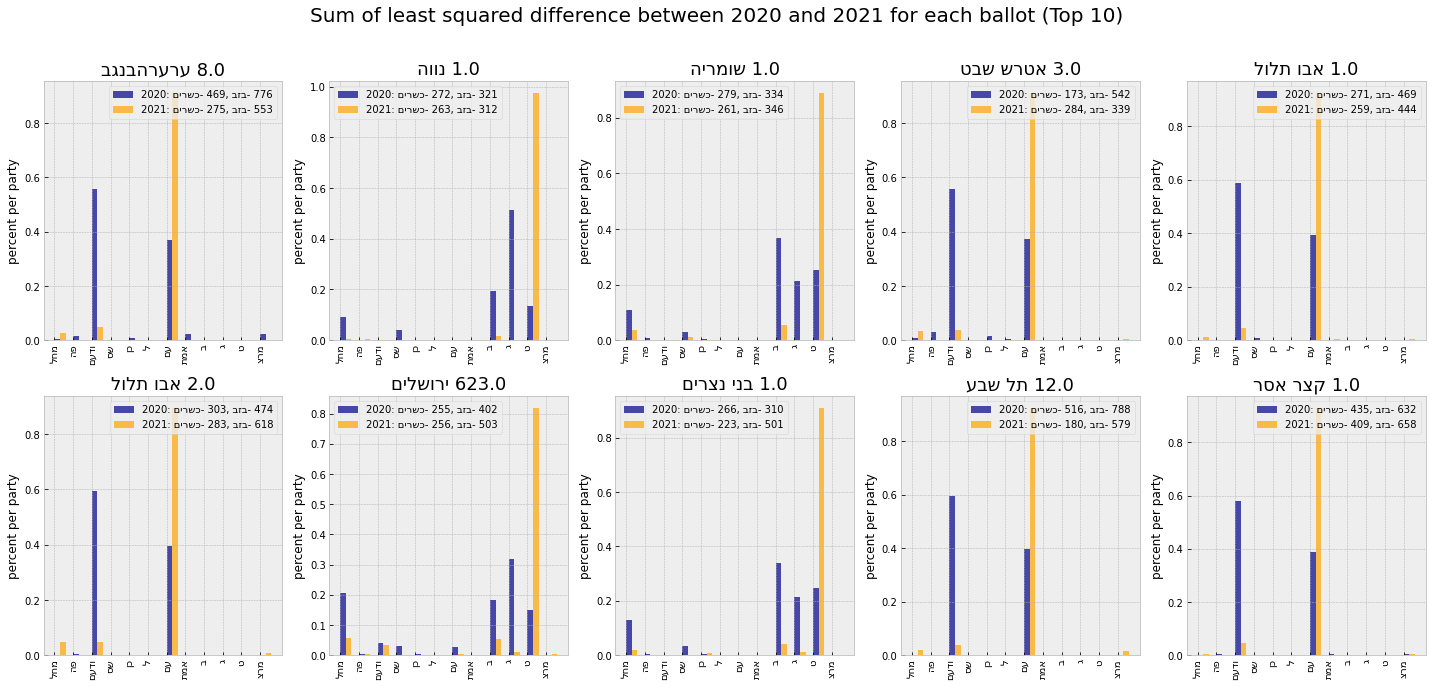

(<Figure size 1440x720 with 10 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7facaa20d810>)

In [ ]:
results_c_final_2021 = plotPreProcessing_c(df_2021_a, results_c, ballot_2021_raw)
results_c_final_2020 = plotPreProcessing_c(df_2020_a, results_c, ballot_2020_raw)
votes_percent_plt(results_c_final_2020, results_c_final_2021, "Sum of least squared difference between 2020 and 2021 for each ballot (Top 10)")


We can see that in most of the parties which are considered as the right side of the politics map ("Yemanim"), the main difference is that most of the votes are voted to "הבית היהודי". [matan please expand why im not good at politics]

As for the Arab settelments its looks more of a change in the arabs party (most of the votes frmo "ודעם" moved to "עם"). [matan please expand why im not good at politics]

So its not that good indicator for detecting fraud ballot - we truly identified anomaly, but probably "right" anomaly.

##### Plot for section h

In [ ]:
def plotPreProcessing(df, results, ballot_df):
  #extract the bzb and the ksherim
  KsherimBzb = getByKalpiAndCity(ballot_df, results).reset_index()[["בזב_x", "כשרים_x","שם ישוב", "קלפי"]]
  # KsherimBzb = getByKalpiAndCity(ballot_df, results).reset_index()
  KsherimBzb.columns = ["בזב", "כשרים","שם ישוב", "קלפי"]
  KsherimBzb.sort_values(by=["שם ישוב", "קלפי"], inplace=True)

  #get only the top10 results data
  tmp = getByKalpiAndCity(df, results.reset_index()[["שם ישוב", "קלפי"]])

  
  tmp.sort_values(by=["שם ישוב", "קלפי"], inplace=True)
  tmp[["כשרים", "בזב"]] = KsherimBzb[["כשרים", "בזב"]]





  tmp["שם ישוב"] = tmp.loc[:, "שם ישוב"].apply(lambda x: x[::-1])

  #make a unique index
  tmp["new_index"] = tmp["שם ישוב"] + " " + tmp["קלפי"].astype(str)
  tmp.set_index("new_index", inplace=True)
  tmp.sort_values(by=["שם ישוב", "קלפי"], inplace=True)
  tmp.drop(["שם ישוב", "קלפי"], inplace=True,axis=1)
  return tmp


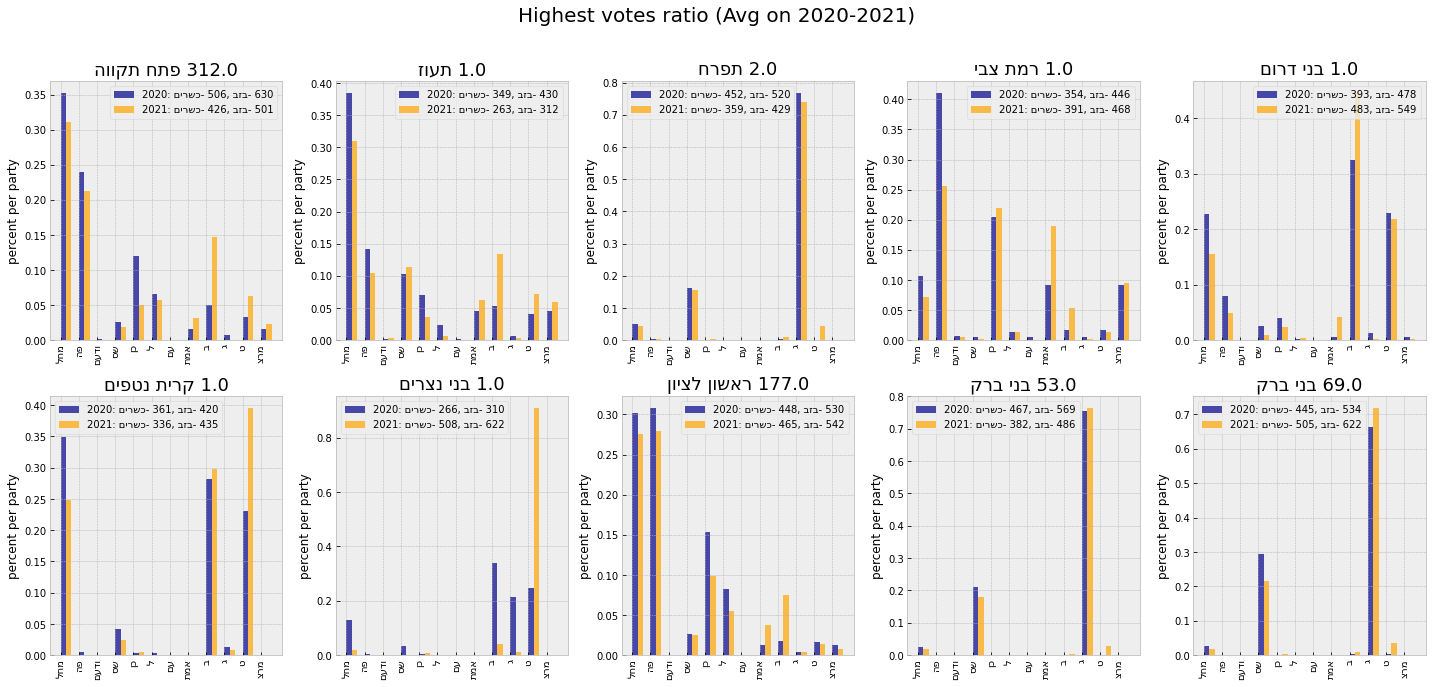

(<Figure size 1440x720 with 10 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fac9f579d90>)

In [ ]:
results_h_final_2021 = plotPreProcessing(df_2021_a, results_h, ballot_2021_raw)
results_h_final_2020 = plotPreProcessing(df_2020_a, results_h, ballot_2020_raw)

votes_percent_plt(results_h_final_2020, results_h_final_2021, "Highest votes ratio (Avg on 2020-2021)")

The results here seems pretty normal and i dont think we can observed fraud ballot here.

The right calculation to do is to check the highest difference in the votes ratio between each year.

##### Plot for section i

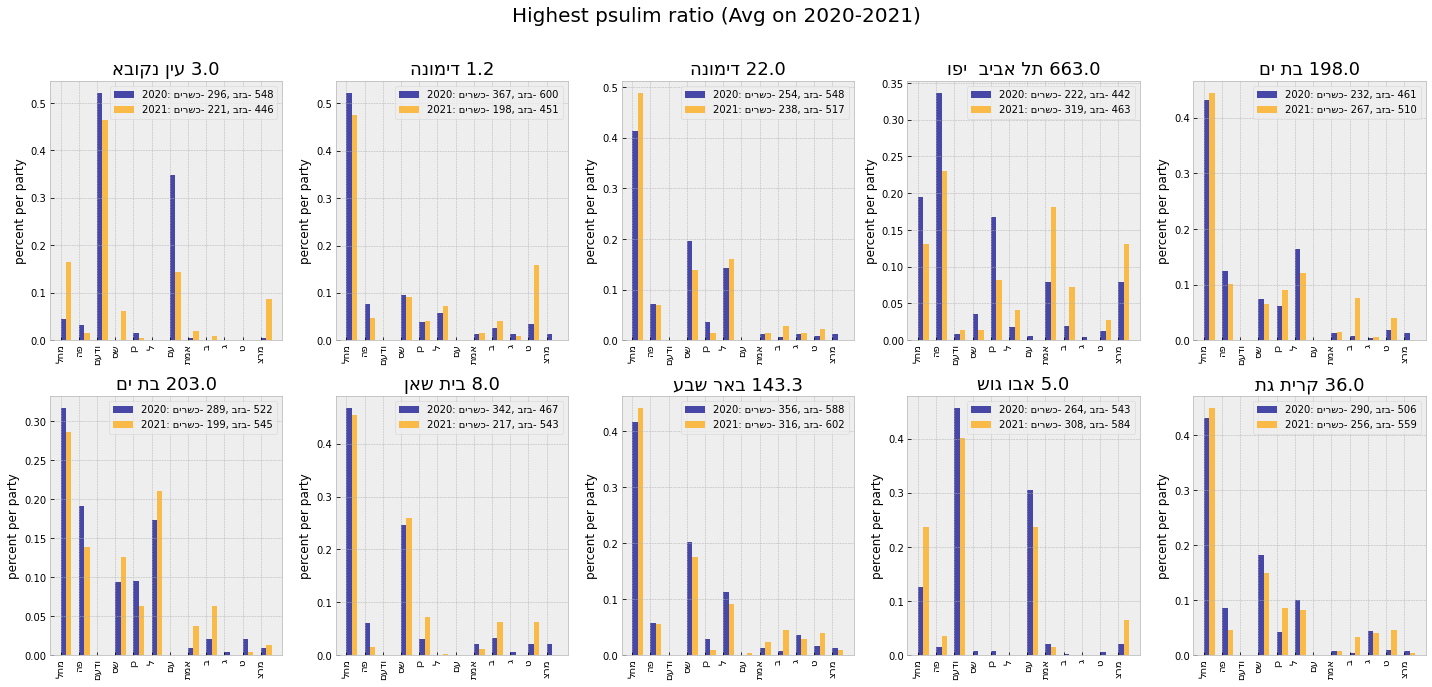

(<Figure size 1440x720 with 10 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fac9ee0edd0>)

In [ ]:
results_i_final_2021 = plotPreProcessing(df_2021_a, results_i, ballot_2021_raw)
results_i_final_2020 = plotPreProcessing(df_2020_a, results_i, ballot_2020_raw)

votes_percent_plt(results_i_final_2020, results_i_final_2021, "Highest psulim ratio (Avg on 2020-2021)")

We can see here that in each one of the Jew settelments, the biggest party is Likud, but we cant assume that it tells us somthing about the data.
Kolot Psulim is really small part of the data, so to check the top 10 psulim is not that right inspection.

The better inspection is to try to predict of which party the Kolot Psulim are coming from. (unsupervised learning when the Y vector is the kolot psulim).

In general, when we trying to inference abot fraud kalpies, the data become pretty imbalanced (low share of the fraud data from the whole sample) for classical machine learning classification.

### Q2.

#### a.

In [ ]:
size_order = (df_2021_a_raw.iloc[:,:-1].sum(axis=0)).sort_values(ascending=False).keys().to_list()


$cov_{x,y}=\frac{\sum_{i=1}^{N}(x_{i}-\bar{x})(y_{i}-\bar{y})}{N-1}$

In [ ]:
from sklearn.covariance import empirical_covariance

cov_2021 = df_2021_a.iloc[:,:-1].cov()
# cov_2021 = df_2021_a_raw.iloc[:,:-1].cov()

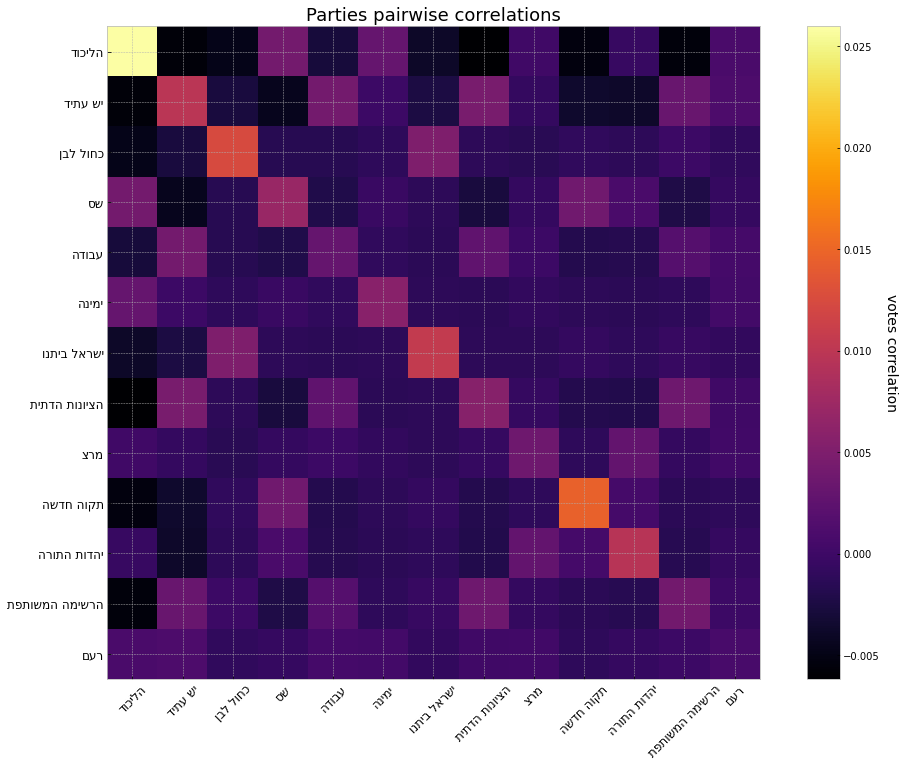

In [ ]:
# Display heatmap for a correlation matrix 
# Input: 
# corr_mat - matrix of correlations 
# names - vector with names for each row/column
def heatmap_corr(corr_mat, names):
    rev_names = [parties_dict[name][::-1] for name in list(names)]
    fig, ax = plt.subplots()
    fig.set_size_inches(17, 12)
    im = ax.imshow(corr_mat, cmap=plt.get_cmap('inferno'))
    n = corr_mat.shape[0]  # get number of variables 
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(rev_names, fontsize=12, rotation=45)
    ax.set_yticklabels(rev_names, fontsize=12)
    ax.set_title("Parties pairwise correlations", fontsize=18)
    
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax) #  **cbar_kw)
    cbar.ax.set_ylabel('votes correlation', rotation=-90, va="bottom", fontsize=14)

heatmap_corr(cov_2021, size_order)

#### b. 

$d(x,y)=(\boldsymbol{x}-\boldsymbol{y})^\top\Sigma^{-1}(\boldsymbol{x}-\boldsymbol{y})$


##### b.

In [ ]:


df_2021 = ballot_2021.iloc[:,[3]+list(range(10,ballot_2021.shape[1]))]
df_2020 = ballot_2020.iloc[:,[3]+list(range(10,ballot_2020.shape[1]))]


df_2021_raw = ballot_2021_raw.iloc[:,[3]+list(range(10,ballot_2021.shape[1]))]
df_2020_raw = ballot_2020_raw.iloc[:,[3]+list(range(10,ballot_2020.shape[1]))]
# df_2021 = ballot_2021[["קלפי"]+ biggest_2021]
# df_2020 = ballot_2020[["קלפי"]+ biggest_2020]

In [ ]:

only_small_cities = bigCitiesFilter(ballot_2020_raw, 50000)

mean_by_city = MeanByCity(only_small_cities)
df_2020_big_cities = df_2020[df_2020.index.isin(only_small_cities.index)]

# df_2020_big_cities = getByKalpiAndCity(df_2020, only_small_cities.reset_index()[["קלפי","שם ישוב"]])
# df_2020_big_cities.set_index("שם ישוב", inplace=True)
kalpis_order = df_2020_big_cities["קלפי"]
df_2020_big_cities_mean = df_2020_big_cities.copy()
for col in df_2020_big_cities_mean.columns:
    df_2020_big_cities_mean[col].values[:] = 0

df_2020_big_cities_mean = df_2020_big_cities_mean.add(mean_by_city, axis=1)
cov_2020_b = df_2020_big_cities.iloc[:,1:].cov()


cov_inv_2020_b = pd.DataFrame(np.linalg.pinv(cov_2020_b.values), cov_2020_b.columns, cov_2020_b.index)
#moor penrose inverse

def mahalanobisD_b(X,Y,cov_inv):
    kalpi = []
    city = []
    m = []
    for i in range(X.shape[0]):
        kalpi.append(X.iloc[i,0])
        city.append(X.reset_index().loc[i,"שם ישוב"])
        m.append(mahalanobis(X.iloc[i,1:],Y.iloc[i,1:],cov_inv))
    
    results = pd.DataFrame(zip(kalpi, city, m), columns=["קלפי", "שם ישוב", "d"])
    return(results)

mD_b_2020 = mahalanobisD_b(df_2020_big_cities ,df_2020_big_cities_mean, cov_inv_2020_b)

In [ ]:
mD_b_2020.set_index("שם ישוב").sort_values(by="d", ascending=False).iloc[:10,::-1]


,d,קלפי
שם ישוב,,
מעלה אדומים,41.8755,31.0000
קרית ביאליק,41.7002,12.0000
מעלה אדומים,41.6648,7.0000
מעלה אדומים,41.6596,24.0000
מעלה אדומים,41.6301,41.0000
מעלה אדומים,41.5938,15.0000
מעלה אדומים,41.5609,44.0000
מעלה אדומים,41.5520,28.0000
מעלה אדומים,41.5481,13.0000


Example:

In [ ]:

compareKalpiWithMean(df_2020, 31.0000, "מעלה אדומים")

,קלפי,אמת,ג,ודעם,ז,זך,זץ,טב,י,יז,ינ,יף,יק,יר,כ,כן,ל,מחל,נ,נז,ני,נץ,נק,פה,ףז,ץ,ק,קי,קך,קץ,שס
top_kalpi,31.0000,0.0186,0.0103,0.0000,0.0000,0.0000,0.0000,0.0639,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1464,0.5856,0.0000,0.0000,0.0000,0.0062,0.0000,0.0887,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0804
mean_by_city,106.5432,0.0158,0.0189,0.0006,0.0007,0.0001,0.0000,0.1206,0.0001,0.0000,0.0000,0.0000,0.0004,0.0001,0.0005,0.0001,0.0592,0.5852,0.0012,0.0002,0.0000,0.0089,0.0001,0.1096,0.0003,0.0000,0.0002,0.0001,0.0001,0.0004,0.0767


In [ ]:
results_b_2020

,SumSquared,קלפי
שם ישוב,,
צפת,1.0670,40.0000
חצור הגלילית,1.0081,3.0000
קרית גת,0.8372,74.0000
מעלותתרשיחא,0.7101,7.0000
מעלותתרשיחא,0.6967,25.0000
נוף הגליל,0.6951,60.0000
מעלותתרשיחא,0.6607,28.0000
עכו,0.6551,46.0000
מעלותתרשיחא,0.6498,3.0000


We can see that we got a totally different results.
It means that Maale adumim have some really diversed neighebrhoods (probably the outliers).

In [ ]:

only_small_cities = bigCitiesFilter(ballot_2021_raw, 50000)

mean_by_city = MeanByCity(only_small_cities)
df_2021_big_cities = df_2021[df_2021.index.isin(only_small_cities.index)]

# df_2021_big_cities = getByKalpiAndCity(df_2021, only_small_cities.reset_index()[["קלפי","שם ישוב"]])
# df_2021_big_cities.set_index("שם ישוב", inplace=True)
kalpis_order = df_2021_big_cities["קלפי"]
df_2021_big_cities_mean = df_2021_big_cities.copy()
for col in df_2021_big_cities_mean.columns:
    df_2021_big_cities_mean[col].values[:] = 0

df_2021_big_cities_mean = df_2021_big_cities_mean.add(mean_by_city, axis=1)
cov_2021_b = df_2021_big_cities.iloc[:,1:].cov()


cov_inv_2021_b = pd.DataFrame(np.linalg.pinv(cov_2021_b.values), cov_2021_b.columns, cov_2021_b.index)
#moor penrose inverse

mD_b_2021 = mahalanobisD_b(df_2021_big_cities ,df_2021_big_cities_mean, cov_inv_2021_b)
mD_b_2021.set_index("שם ישוב").sort_values(by="d", ascending=False).iloc[:10,::-1]


,d,קלפי
שם ישוב,,
רהט,55.2726,21.2000
נס ציונה,55.2032,3.2000
נס ציונה,55.1156,30.0000
נס ציונה,55.0647,32.0000
נס ציונה,55.0425,35.2000
נס ציונה,55.0318,2.0000
נס ציונה,55.0218,16.4000
נס ציונה,55.0193,13.3000
נס ציונה,55.0123,16.3000


In [ ]:

compareKalpiWithMean(df_2021, 21.2000, "רהט")




,קלפי,אמת,ב,ג,ודעם,ז,זץ,ט,י,יז,ינ,יף,יק,יר,כ,כך,כן,ל,מחל,מרצ,נ,ני,נר,עם,פה,ףז,צי,צכ,צף,ץ,ק,קי,קך,קץ,ר,רנ,רף,רק,שס,ת
top_kalpi,21.2000,0.0000,0.0000,0.0035,0.1923,0.0000,0.0000,0.0000,0.0035,0.3252,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0070,0.0000,0.1678,0.0070,0.0000,0.0000,0.0000,0.2622,0.0035,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0070,0.0000,0.0000,0.0000,0.0000,0.0210
mean_by_city,31.4077,0.0045,0.0007,0.0006,0.2236,0.0002,0.0001,0.0000,0.0001,0.0290,0.0002,0.0001,0.0002,0.0003,0.0002,0.0005,0.0023,0.0006,0.0615,0.0270,0.0001,0.0004,0.0004,0.6289,0.0050,0.0002,0.0003,0.0004,0.0005,0.0001,0.0004,0.0007,0.0010,0.0005,0.0003,0.0007,0.0007,0.0000,0.0009,0.0069


In [ ]:
compareKalpiWithMean(df_2021, 31.1000, "מעלה אדומים")

,קלפי,אמת,ב,ג,ודעם,ז,זץ,ט,י,יז,ינ,יף,יק,יר,כ,כך,כן,ל,מחל,מרצ,נ,ני,נר,עם,פה,ףז,צי,צכ,צף,ץ,ק,קי,קך,קץ,ר,רנ,רף,רק,שס,ת
top_kalpi,31.1000,0.0136,0.1417,0.0054,0.0000,0.0000,0.0000,0.1117,0.0000,0.0109,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0191,0.0300,0.4523,0.0082,0.0000,0.0000,0.0000,0.0000,0.0545,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0027,0.0000,0.0000,0.0817,0.0681
mean_by_city,148.7635,0.0156,0.1158,0.0097,0.0004,0.0000,0.0000,0.1086,0.0002,0.0058,0.0000,0.0000,0.0009,0.0001,0.0002,0.0004,0.0296,0.0471,0.4639,0.0056,0.0001,0.0002,0.0000,0.0002,0.0573,0.0002,0.0000,0.0000,0.0000,0.0000,0.0001,0.0001,0.0001,0.0003,0.0039,0.0003,0.0001,0.0000,0.0685,0.0649


In [ ]:
results_b_2021

,SumSquared,קלפי
שם ישוב,,
נוף הגליל,0.6720,1.3000
מעלותתרשיחא,0.5973,1.2000
מעלותתרשיחא,0.5375,1.0000
טבריה,0.5042,12.3000
נוף הגליל,0.4947,1.0000
מגדל העמק,0.4859,1.1000
נוף הגליל,0.4593,1.0000
מעלותתרשיחא,0.4501,1.0000
עכו,0.4485,1.0000


The same here, we can see that the weights of the inverse covariance matrix did a real impact on the results.

##### c.



$\sum_{i=1}^{C}\sum_{b \in ballot}^{B}\sum_{j=1}^{K}(n_{bij}^{2020}-n_{bij}^{2021})^2$


Sort by biggest

In [ ]:
cov_inv_2021 = pd.DataFrame(np.linalg.pinv(cov_2021.values), cov_2021.columns, cov_2021.index)


def mahalanobisD(X,Y,cov_inv):
    kalpi = []
    city = []
    m = []
    for i in range(X.shape[0]):
        kalpi.append(X.iloc[i,-1])
        city.append(X.reset_index().loc[i,"שם ישוב"])
        m.append(mahalanobis(X.iloc[i,:-1],Y.iloc[i,:-1],cov_inv))
    
    results = pd.DataFrame(zip(kalpi, city, m), columns=["קלפי", "שם ישוב", "d"])
    return(results)
mD = mahalanobisD(df_2020_a,df_2021_a,cov_inv_2021)



In [ ]:
results_c_md = mD.set_index("שם ישוב").sort_values(by="d", ascending=False).iloc[:10,::-1]
results_c_md

,d,קלפי
שם ישוב,,
כדיתה,13.9224,1.0000
נווה,13.8000,1.0000
אלוני יצחק,13.5210,1.0000
בני נצרים,12.7089,1.0000
שומריה,12.7061,1.0000
כרם יבנה ישיבה,11.8919,1.0000
אלון מורה,11.5087,1.0000
משכיות,11.4288,1.0000
פני חבר,11.0996,1.0000


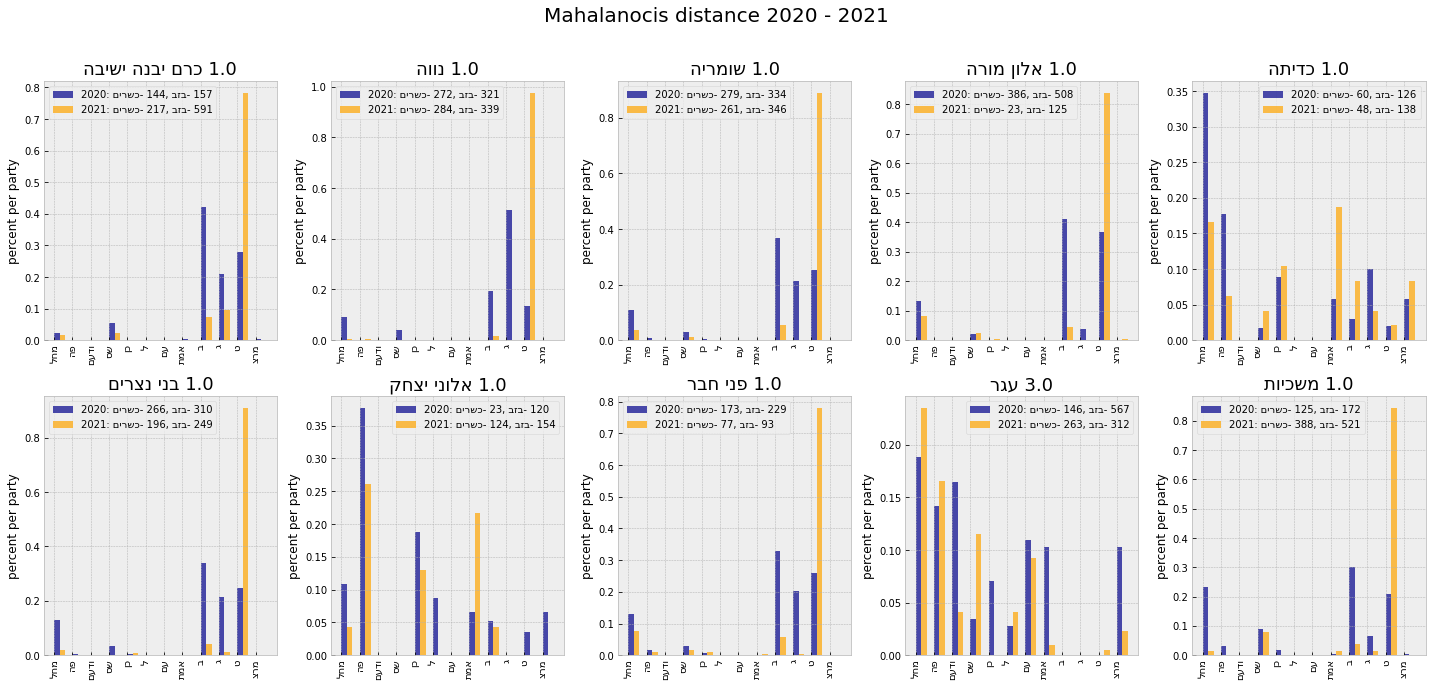

(<Figure size 1440x720 with 10 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fac96696810>)

In [ ]:
results_c_final_2021_md = plotPreProcessing_c(df_2021_a, results_c_md, ballot_2021_raw)
results_c_final_2020_md = plotPreProcessing_c(df_2020_a, results_c_md, ballot_2020_raw)
votes_percent_plt(results_c_final_2020_md, results_c_final_2021_md, "Mahalanocis distance 2020 - 2021")


Here we can see an interesting pattern - the results of sum squared was not that informative because of the votes that moved to "הבית היהודי" and to "עם".
Here we dont see Arab settelemnts at all, and we see that the same pattern with "הבית היהודי" is happening also here.
But if we wil look at Kadita, Alonei Itzhak and Ajar - it looks like a whole different pattern.

